# BioClinical ModernBERT MCD Analysis

# 1. Project Setup

In [1]:
%pip install transformers torch numpy scipy pandas seaborn matplotlib scikit-learn tqdm datasets

# 2. `MonteCarloDropoutClassifier` Class Setup

In [2]:
# Code from intern
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.stats import entropy

class MonteCarloDropoutClassifier:
    def __init__(self, model_path, n_iterations=50, inference_dropout_rate=0.05, device=None):
        self.n_iterations = n_iterations
        self.inference_dropout_rate = inference_dropout_rate  # NEW PARAMETER
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

    def enable_dropout_with_rate(self, dropout_rate=None):
        """
        Enable dropout layers with a specified rate (or use default).
        For MC Dropout, use LOWER rate than training (e.g., 0.05 instead of 0.1)
        """
        if dropout_rate is None:
            dropout_rate = self.inference_dropout_rate

        for module in self.model.modules():
            if module.__class__.__name__.startswith('Dropout'):
                # Set custom dropout rate for inference
                module.p = dropout_rate
                module.train()
            elif 'Norm' in module.__class__.__name__:
                module.eval()

    def predict_with_uncertainty(self, text):
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True
        ).to(self.device)

        # Use LOWER dropout rate for inference
        self.enable_dropout_with_rate(dropout_rate=self.inference_dropout_rate)

        all_predictions = []

        with torch.no_grad():
            for _ in range(self.n_iterations):
                outputs = self.model(**inputs)
                probabilities = torch.softmax(outputs.logits, dim=-1)
                all_predictions.append(probabilities.cpu().numpy())

        # Stack predictions (shape: n_iterations, batch_size, n_classes)
        all_predictions = np.stack(all_predictions)

        # Calculate statistics
        mean_probs = all_predictions.mean(axis=0)  # Average probabilities
        std_probs = all_predictions.std(axis=0)    # Standard deviation

        # Predicted class (highest mean probability)
        predicted_class = mean_probs.argmax(axis=-1)
        confidence = mean_probs.max(axis=-1)

        # Uncertainty metrics
        predictive_entropy = entropy(mean_probs, axis=-1)
        mutual_information = self.compute_mutual_information(all_predictions)

        return {
            "predicted_class": predicted_class,
            "predicted_label": [self.model.config.id2label[idx] for idx in predicted_class],
            "mean_probabilities": mean_probs,
            "std_probabilities": std_probs,
            "confidence": confidence,
            "predictive_entropy": predictive_entropy,
            "mutual_information": mutual_information,
            "all_predictions": all_predictions  # For further analysis
        }

    def compute_mutual_information(self, predictions):
        """
        Compute mutual information as measure of epistemic uncertainty.
        MI = H(E[p]) - E[H(p)]
        """
        # Expected entropy: average of entropies
        expected_entropy = np.mean([entropy(p, axis=-1) for p in predictions], axis=0)

        # Entropy of expected probabilities
        mean_probs = predictions.mean(axis=0)
        entropy_of_expected = entropy(mean_probs, axis=-1)

        return entropy_of_expected - expected_entropy

In [3]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `colabbb` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate 

# 3. Dataset Setup

In [4]:
from datasets import load_dataset
from transformers import set_seed, AutoModelForSequenceClassification, AutoTokenizer

set_seed(42)

# Load the model first to get the CORRECT label mapping
model_path = "notlath/BioClinical-ModernBERT-base-Symptom2Disease_WITH-DROPOUT-42"
model_config = AutoModelForSequenceClassification.from_pretrained(model_path).config
tokenizer = AutoTokenizer.from_pretrained(model_path)

# ✅ Use the model's label mapping
label2id = model_config.label2id
id2label = model_config.id2label

print(f"✅ Using model's label mapping with {len(label2id)} classes")
print(f"Label mapping: {id2label}")

full_dataset = load_dataset("notlath/eng_dataset")

def preprocess_labels(example):
    return {
        'text': example['text'],
        'label': example['label']
    }

# Access the correct split name - inspect full_dataset keys
# print(full_dataset.keys()) # Uncomment this line to see available keys
# Based on the dataset card or common practice, the split name might be 'train'
processed_dataset = full_dataset['train'].map(preprocess_labels)

# Convert labels to integers using MODEL'S mapping
def convert_labels_to_ids(example):
    return {
        'text': example['text'],
        'labels': label2id[example['label']]
    }

processed_dataset = processed_dataset.map(convert_labels_to_ids, remove_columns=['label'])

# ✅ BETTER SPLIT: 70% train, 15% validation, 15% test
# This gives you MORE test samples for reliable K-fold
train_test_split = processed_dataset.train_test_split(test_size=0.3, seed=42)  # 70-30
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)  # 15-15

dataset = {
    'train': train_test_split['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
}

print(f"\n📊 Dataset Splits:")
print(f"   Train: {len(dataset['train'])} samples")
print(f"   Validation: {len(dataset['validation'])} samples")
print(f"   Test: {len(dataset['test'])} samples")

# ✅ Check class distribution in test set
from collections import Counter
test_labels = dataset['test']['labels']
label_counts = Counter(test_labels)
print(f"\n🔍 Test Set Class Distribution:")
for label_id, count in sorted(label_counts.items()):
    print(f"   {id2label[label_id]:15s}: {count} samples")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

✅ Using model's label mapping with 6 classes
Label mapping: {0: 'Measles', 1: 'Dengue', 2: 'Diarrhea', 3: 'Typhoid', 4: 'Influenza', 5: 'Pneumonia'}


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/473k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]


📊 Dataset Splits:
   Train: 2100 samples
   Validation: 450 samples
   Test: 450 samples

🔍 Test Set Class Distribution:
   Measles        : 84 samples
   Dengue         : 74 samples
   Diarrhea       : 65 samples
   Typhoid        : 73 samples
   Influenza      : 79 samples
   Pneumonia      : 75 samples


# 4. K-Fold Cross Validation Setup using `MCDCrossValidator`

In [5]:
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer

class MCDCrossValidator:
    def __init__(self, classifier, dataset, tokenizer, n_splits=5, groups=None):
        """
        K-fold cross-validation for Monte Carlo Dropout evaluation.

        Args:
            classifier: Your MonteCarloDropoutClassifier instance
            dataset: Your test dataset (HuggingFace dataset format with 'text' and 'labels')
            tokenizer: The tokenizer used by the classifier
            n_splits: Number of folds
            groups: Optional group ids for GroupKFold (e.g., paraphrase groups)
        """
        self.classifier = classifier
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.n_splits = n_splits
        self.groups = groups
        self.results = []

    def evaluate_fold(self, fold_data):
        """
        Evaluate MCD on a single fold.

        Returns:
            dict with metrics for this fold
        """
        # 🔍 DIAGNOSTIC LOGGING
        print(f"\n🔍 DIAGNOSTIC INFO:")
        print(f"   Fold data size: {len(fold_data)}")
        print(f"   Sample text: {fold_data[0]['text'][:100]}...")
        print(f"   Sample label ID (dataset): {fold_data[0]['labels']}")

        # Check if model's label mapping matches dataset
        if hasattr(self.classifier.model.config, 'id2label'):
            print(f"   Model has {len(self.classifier.model.config.id2label)} classes")
            print(f"   Model id2label sample: {list(self.classifier.model.config.id2label.items())[:3]}")

        all_predictions = []
        all_labels = []
        all_confidences = []
        all_uncertainties = []
        all_entropies = []
        all_texts = []

        # Iterate through fold data
        for i in tqdm(range(len(fold_data)), desc="Evaluating fold"):
            text = fold_data[i]['text']
            true_label = fold_data[i]['labels']

            # Get MCD prediction with uncertainty
            result = self.classifier.predict_with_uncertainty(text)

            predicted_class = result['predicted_class'][0]
            confidence = result['confidence'][0]
            mi = result['mutual_information'][0]
            entropy_val = result['predictive_entropy'][0]

            # 🔍 DEBUG: Check first few samples for label mismatch
            if i < 3:
                print(f"\n   Sample {i}:")
                print(f"      True label ID: {true_label}")
                print(f"      Predicted ID: {predicted_class}")
                print(f"      Model's interpretation of true label: {self.classifier.model.config.id2label.get(true_label, 'UNKNOWN')}")
                print(f"      Model's prediction: {result['predicted_label'][0]}")

            all_predictions.append(predicted_class)
            all_labels.append(true_label)
            all_confidences.append(confidence)
            all_uncertainties.append(mi)
            all_entropies.append(entropy_val)
            all_texts.append(text)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        # Calculate precision, recall, f1-score
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted', zero_division=0)


        # 🔍 Show confusion for debugging
        if accuracy < 0.5:  # If accuracy suspiciously low
            print(f"\n⚠️  LOW ACCURACY DETECTED: {accuracy:.4f}")
            print(f"   Unique true labels: {set(all_labels)}")
            print(f"   Unique predictions: {set(all_predictions)}")
            print(f"   Label range in dataset: {min(all_labels)} to {max(all_labels)}")
            print(f"   Prediction range: {min(all_predictions)} to {max(all_predictions)}")

        # Calculate calibration metrics
        correct_predictions = np.array(all_predictions) == np.array(all_labels)
        avg_confidence_correct = np.mean([all_confidences[i] for i in range(len(correct_predictions)) if correct_predictions[i]]) if any(correct_predictions) else 0
        avg_confidence_incorrect = np.mean([all_confidences[i] for i in range(len(correct_predictions)) if not correct_predictions[i]]) if not all(correct_predictions) else 0

        avg_uncertainty_correct = np.mean([all_uncertainties[i] for i in range(len(correct_predictions)) if correct_predictions[i]]) if any(correct_predictions) else 0
        avg_uncertainty_incorrect = np.mean([all_uncertainties[i] for i in range(len(correct_predictions)) if not correct_predictions[i]]) if not all(correct_predictions) else 0

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mean_confidence': np.mean(all_confidences),
            'std_confidence': np.std(all_confidences),
            'mean_uncertainty': np.mean(all_uncertainties),
            'std_uncertainty': np.std(all_uncertainties),
            'mean_entropy': np.mean(all_entropies),
            'confidence_correct': avg_confidence_correct,
            'confidence_incorrect': avg_confidence_incorrect,
            'uncertainty_correct': avg_uncertainty_correct,
            'uncertainty_incorrect': avg_uncertainty_incorrect,
            'predictions': all_predictions,
            'labels': all_labels,
            'confidences': all_confidences,
            'uncertainties': all_uncertainties,
            'texts': all_texts
        }

    def run_kfold_evaluation(self):
        """
        Run K-fold cross-validation on the test set.

        Returns:
            dict with aggregated results across all folds
        """
        print(f"\n{'='*80}")
        print(f"🔬 Starting {self.n_splits}-Fold Cross-Validation with Monte Carlo Dropout")
        print(f"{'='*80}\n")

        # Convert dataset to pandas for easier splitting
        if hasattr(self.dataset, 'to_pandas'):
            dataset_df = self.dataset.to_pandas()
        else:
            # If already a dict with text and labels
            dataset_df = pd.DataFrame({
                'text': self.dataset['text'],
                'labels': self.dataset['labels']
            })

        # Determine groups if available
        groups = None
        if self.groups is not None:
            groups = np.array(self.groups)
            print("✅ Using GroupKFold with provided group ids")
            print(f"   Unique groups: {len(np.unique(groups))}")

        fold_results = []

        if groups is not None:
            splitter = GroupKFold(n_splits=self.n_splits)
            split_iter = splitter.split(dataset_df, groups=groups)
        else:
            splitter = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
            split_iter = splitter.split(dataset_df)

        for fold_idx, (_, test_idx) in enumerate(split_iter):
            print(f"\n📊 Fold {fold_idx + 1}/{self.n_splits}")
            print("-" * 80)

            # Get fold data
            fold_data = self.dataset.select(np.array(test_idx).tolist())

            # Evaluate this fold
            fold_result = self.evaluate_fold(fold_data)
            fold_result['fold'] = fold_idx + 1
            fold_results.append(fold_result)

            # Print fold summary
            print(f"\n✅ Fold {fold_idx + 1} Results:")
            print(f"   Accuracy: {fold_result['accuracy']:.4f}")
            print(f"   Precision: {fold_result['precision']:.4f}")
            print(f"   Recall: {fold_result['recall']:.4f}")
            print(f"   F1-Score: {fold_result['f1']:.4f}")
            print(f"   Mean Confidence: {fold_result['mean_confidence']:.4f} ± {fold_result['std_confidence']:.4f}")
            print(f"   Mean Uncertainty (MI): {fold_result['mean_uncertainty']:.4f} ± {fold_result['std_uncertainty']:.4f}")
            print(f"   Confidence (Correct): {fold_result['confidence_correct']:.4f}")
            print(f"   Confidence (Incorrect): {fold_result['confidence_incorrect']:.4f}")
            print(f"   Uncertainty (Correct): {fold_result['uncertainty_correct']:.4f}")
            print(f"   Uncertainty (Incorrect): {fold_result['uncertainty_incorrect']:.4f}")

        # Aggregate results
        aggregated = self._aggregate_results(fold_results)
        self.results = fold_results

        return aggregated, fold_results

    def _aggregate_results(self, fold_results):
        """Aggregate metrics across all folds, including calibration (ECE) and reliability data."""
        print(f"\n{'='*80}")
        print(f"📈 AGGREGATED RESULTS ACROSS {self.n_splits} FOLDS")
        print(f"{'='*80}\n")

        # Calculate mean and std for each metric
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'mean_confidence', 'mean_uncertainty', 'mean_entropy',
                   'confidence_correct', 'confidence_incorrect',
                   'uncertainty_correct', 'uncertainty_incorrect']

        aggregated = {}
        for metric in metrics:
            values = [fold[metric] for fold in fold_results]
            aggregated[f'{metric}_mean'] = float(np.mean(values))
            aggregated[f'{metric}_std'] = float(np.std(values))
            print(f"{metric:25s}: {np.mean(values):.4f} ± {np.std(values):.4f}")

        # Additional derived metrics
        accuracy_per_fold = [float(fold['accuracy']) for fold in fold_results]
        confidence_gap_values = [float(fold['confidence_correct'] - fold['confidence_incorrect']) for fold in fold_results]
        uncertainty_sep_values = [float(fold['uncertainty_incorrect'] - fold['uncertainty_correct']) for fold in fold_results]

        aggregated['accuracy_per_fold'] = accuracy_per_fold
        aggregated['confidence_gap_mean'] = float(np.mean(confidence_gap_values))
        aggregated['confidence_gap_std'] = float(np.std(confidence_gap_values))
        aggregated['uncertainty_separation_mean'] = float(np.mean(uncertainty_sep_values))
        aggregated['uncertainty_separation_std'] = float(np.std(uncertainty_sep_values))

        print(f"{'confidence_gap':25s}: {aggregated['confidence_gap_mean']:.4f} ± {aggregated['confidence_gap_std']:.4f}")
        print(f"{'uncertainty_separation':25s}: {aggregated['uncertainty_separation_mean']:.4f} ± {aggregated['uncertainty_separation_std']:.4f}")

        # Compute ECE per fold and aggregated reliability diagram data
        def compute_ece(conf, preds, labels, n_bins=15):
            conf = np.asarray(conf)
            preds = np.asarray(preds)
            labels = np.asarray(labels)
            bins = np.linspace(0.0, 1.0, n_bins + 1)
            ece = 0.0
            bin_data = []
            for i in range(n_bins):
                bin_lower, bin_upper = bins[i], bins[i + 1]
                in_bin = (conf > bin_lower) & (conf <= bin_upper) if i > 0 else (conf >= bin_lower) & (conf <= bin_upper)
                if np.any(in_bin):
                    acc = np.mean(preds[in_bin] == labels[in_bin])
                    avg_conf = float(np.mean(conf[in_bin]))
                    weight = np.mean(in_bin)
                    ece += weight * abs(acc - avg_conf)
                    bin_data.append({
                        'bin': i,
                        'lower': float(bin_lower),
                        'upper': float(bin_upper),
                        'count': int(np.sum(in_bin)),
                        'accuracy': float(acc),
                        'avg_confidence': avg_conf,
                    })
                else:
                    bin_data.append({
                        'bin': i,
                        'lower': float(bin_lower),
                        'upper': float(bin_upper),
                        'count': 0,
                        'accuracy': None,
                        'avg_confidence': None,
                    })
            return float(ece), bin_data

        ece_values = []
        for fold in fold_results:
            ece_val, _ = compute_ece(fold['confidences'], fold['predictions'], fold['labels'])
            ece_values.append(ece_val)
        aggregated['expected_calibration_error_mean'] = float(np.mean(ece_values))
        aggregated['expected_calibration_error_std'] = float(np.std(ece_values))

        # Reliability diagram data (combined across folds)
        all_conf = np.concatenate([np.array(f['confidences']) for f in fold_results])
        all_preds = np.concatenate([np.array(f['predictions']) for f in fold_results])
        all_labels = np.concatenate([np.array(f['labels']) for f in fold_results])
        ece_overall, reliability_bins = compute_ece(all_conf, all_preds, all_labels)
        aggregated['expected_calibration_error_overall'] = float(ece_overall)
        aggregated['reliability_diagram_data'] = reliability_bins

        print(f"{'ECE (mean)':25s}: {aggregated['expected_calibration_error_mean']:.4f} ± {aggregated['expected_calibration_error_std']:.4f}")
        print(f"{'ECE (overall)':25s}: {aggregated['expected_calibration_error_overall']:.4f}")

        print(f"\n{'='*80}\n")
        return aggregated

    def plot_results(self):
        """Visualize K-fold results."""
        import matplotlib.pyplot as plt
        import seaborn as sns

        if not self.results:
            print("⚠️ Run run_kfold_evaluation() first!")
            return

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # 1. Accuracy across folds
        folds = [r['fold'] for r in self.results]
        accuracies = [r['accuracy'] for r in self.results]
        axes[0, 0].bar(folds, accuracies, alpha=0.7, color='skyblue')
        axes[0, 0].axhline(y=np.mean(accuracies), color='red', linestyle='--',
                           label=f'Mean: {np.mean(accuracies):.4f}')
        axes[0, 0].set_xlabel('Fold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_title('Accuracy Across Folds')
        axes[0, 0].legend()
        axes[0, 0].set_ylim([0, 1])

        # 2. Confidence: Correct vs Incorrect
        conf_correct = [r['confidence_correct'] for r in self.results]
        conf_incorrect = [r['confidence_incorrect'] for r in self.results]
        x = np.arange(len(folds))
        width = 0.35
        axes[0, 1].bar(x - width/2, conf_correct, width, label='Correct Predictions', alpha=0.7, color='green')
        axes[0, 1].bar(x + width/2, conf_incorrect, width, label='Incorrect Predictions', alpha=0.7, color='red')
        axes[0, 1].set_xlabel('Fold')
        axes[0, 1].set_ylabel('Mean Confidence')
        axes[0, 1].set_title('Confidence: Correct vs Incorrect Predictions')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels(folds)
        axes[0, 1].legend()

        # 3. Uncertainty: Correct vs Incorrect
        unc_correct = [r['uncertainty_correct'] for r in self.results]
        unc_incorrect = [r['uncertainty_incorrect'] for r in self.results]
        axes[1, 0].bar(x - width/2, unc_correct, width, label='Correct Predictions', alpha=0.7, color='green')
        axes[1, 0].bar(x + width/2, unc_incorrect, width, label='Incorrect Predictions', alpha=0.7, color='red')
        axes[1, 0].set_xlabel('Fold')
        axes[1, 0].set_ylabel('Mean Uncertainty (MI)')
        axes[1, 0].set_title('Uncertainty: Correct vs Incorrect Predictions')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(folds)
        axes[1, 0].legend()

        # 4. Confidence vs Uncertainty scatter (all folds combined)
        all_confidences = []
        all_uncertainties = []
        all_correct = []

        for fold in self.results:
            for i in range(len(fold['predictions'])):
                all_confidences.append(fold['confidences'][i])
                all_uncertainties.append(fold['uncertainties'][i])
                all_correct.append(fold['predictions'][i] == fold['labels'][i])

        colors = ['green' if c else 'red' for c in all_correct]
        axes[1, 1].scatter(all_confidences, all_uncertainties, c=colors, alpha=0.3, s=10)
        axes[1, 1].set_xlabel('Confidence')
        axes[1, 1].set_ylabel('Uncertainty (MI)')
        axes[1, 1].set_title('Confidence vs Uncertainty (All Predictions)')
        axes[1, 1].axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='High Uncertainty')
        axes[1, 1].axvline(x=0.7, color='blue', linestyle='--', alpha=0.5, label='High Confidence')
        axes[1, 1].legend()

        # 5. F1, Precision, Recall across folds
        f1_scores = [r['f1'] for r in self.results]
        precision_scores = [r['precision'] for r in self.results]
        recall_scores = [r['recall'] for r in self.results]

        axes[0, 2].plot(folds, f1_scores, 'o-', label='F1-Score', color='teal')
        axes[0, 2].plot(folds, precision_scores, 'o-', label='Precision', color='magenta')
        axes[0, 2].plot(folds, recall_scores, 'o-', label='Recall', color='darkorange')
        axes[0, 2].axhline(y=np.mean(f1_scores), color='teal', linestyle='--', alpha=0.7)
        axes[0, 2].axhline(y=np.mean(precision_scores), color='magenta', linestyle='--', alpha=0.7)
        axes[0, 2].axhline(y=np.mean(recall_scores), color='darkorange', linestyle='--', alpha=0.7)
        axes[0, 2].set_xlabel('Fold')
        axes[0, 2].set_ylabel('Score')
        axes[0, 2].set_title('F1, Precision, Recall Across Folds')
        axes[0, 2].legend()
        axes[0, 2].set_ylim([0, 1.05])
        axes[0, 2].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()


🚀 STARTING K-FOLD MONTE CARLO DROPOUT EVALUATION

✅ Model loaded: notlath/BioClinical-ModernBERT-base-Symptom2Disease_WITH-DROPOUT-42
   Number of classes: 6
   Classes: ['Measles', 'Dengue', 'Diarrhea', 'Typhoid', 'Influenza', 'Pneumonia']
   Monte Carlo iterations: 50
   Inference dropout rate: 0.05
ℹ️ Group ids not found; falling back to regular KFold.

🔬 Starting 5-Fold Cross-Validation with Monte Carlo Dropout


📊 Fold 1/5
--------------------------------------------------------------------------------

🔍 DIAGNOSTIC INFO:
   Fold data size: 90
   Sample text: Symptoms exploded within hours starting early yesterday with profound muscle aches and exhaustion. D...
   Sample label ID (dataset): 0
   Model has 6 classes
   Model id2label sample: [(0, 'Measles'), (1, 'Dengue'), (2, 'Diarrhea')]


Evaluating fold:   0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W0129 09:15:40.115000 382 torch/_inductor/utils.py:1558] [1/0_1] Not enough SMs to use max_autotune_gemm mode
Evaluating fold:   1%|          | 1/90 [00:21<32:23, 21.84s/it]


   Sample 0:
      True label ID: 0
      Predicted ID: 0
      Model's interpretation of true label: Measles
      Model's prediction: Measles


Evaluating fold:   2%|▏         | 2/90 [00:23<14:22,  9.80s/it]


   Sample 1:
      True label ID: 5
      Predicted ID: 5
      Model's interpretation of true label: Pneumonia
      Model's prediction: Pneumonia


Evaluating fold:   3%|▎         | 3/90 [00:24<08:38,  5.96s/it]


   Sample 2:
      True label ID: 0
      Predicted ID: 4
      Model's interpretation of true label: Measles
      Model's prediction: Influenza


Evaluating fold: 100%|██████████| 90/90 [02:36<00:00,  1.74s/it]



✅ Fold 1 Results:
   Accuracy: 0.9889
   Precision: 0.9899
   Recall: 0.9889
   F1-Score: 0.9890
   Mean Confidence: 0.9069 ± 0.0682
   Mean Uncertainty (MI): 0.0023 ± 0.0064
   Confidence (Correct): 0.9114
   Confidence (Incorrect): 0.5080
   Uncertainty (Correct): 0.0017
   Uncertainty (Incorrect): 0.0529

📊 Fold 2/5
--------------------------------------------------------------------------------

🔍 DIAGNOSTIC INFO:
   Fold data size: 90
   Sample text: For the last three days, a 103.0°F fever has been accompanied by a severe headache. My joints are ac...
   Sample label ID (dataset): 1
   Model has 6 classes
   Model id2label sample: [(0, 'Measles'), (1, 'Dengue'), (2, 'Diarrhea')]


Evaluating fold:   1%|          | 1/90 [00:01<02:00,  1.36s/it]


   Sample 0:
      True label ID: 1
      Predicted ID: 1
      Model's interpretation of true label: Dengue
      Model's prediction: Dengue


Evaluating fold:   2%|▏         | 2/90 [00:02<02:02,  1.40s/it]


   Sample 1:
      True label ID: 2
      Predicted ID: 2
      Model's interpretation of true label: Diarrhea
      Model's prediction: Diarrhea


Evaluating fold:   3%|▎         | 3/90 [00:04<01:59,  1.38s/it]


   Sample 2:
      True label ID: 3
      Predicted ID: 3
      Model's interpretation of true label: Typhoid
      Model's prediction: Typhoid


Evaluating fold: 100%|██████████| 90/90 [02:07<00:00,  1.42s/it]



✅ Fold 2 Results:
   Accuracy: 0.9889
   Precision: 0.9897
   Recall: 0.9889
   F1-Score: 0.9889
   Mean Confidence: 0.9128 ± 0.0446
   Mean Uncertainty (MI): 0.0017 ± 0.0049
   Confidence (Correct): 0.9164
   Confidence (Incorrect): 0.5866
   Uncertainty (Correct): 0.0012
   Uncertainty (Incorrect): 0.0454

📊 Fold 3/5
--------------------------------------------------------------------------------

🔍 DIAGNOSTIC INFO:
   Fold data size: 90
   Sample text: I'm on day three of a sudden high fever, chills, and aches that feel deep in my bones. I'm exhausted...
   Sample label ID (dataset): 3
   Model has 6 classes
   Model id2label sample: [(0, 'Measles'), (1, 'Dengue'), (2, 'Diarrhea')]


Evaluating fold:   1%|          | 1/90 [00:01<02:19,  1.56s/it]


   Sample 0:
      True label ID: 3
      Predicted ID: 3
      Model's interpretation of true label: Typhoid
      Model's prediction: Typhoid


Evaluating fold:   2%|▏         | 2/90 [00:02<02:06,  1.44s/it]


   Sample 1:
      True label ID: 4
      Predicted ID: 4
      Model's interpretation of true label: Influenza
      Model's prediction: Influenza


Evaluating fold:   3%|▎         | 3/90 [00:04<02:01,  1.40s/it]


   Sample 2:
      True label ID: 0
      Predicted ID: 0
      Model's interpretation of true label: Measles
      Model's prediction: Measles


Evaluating fold: 100%|██████████| 90/90 [02:07<00:00,  1.42s/it]



✅ Fold 3 Results:
   Accuracy: 0.9889
   Precision: 0.9894
   Recall: 0.9889
   F1-Score: 0.9888
   Mean Confidence: 0.9064 ± 0.0624
   Mean Uncertainty (MI): 0.0035 ± 0.0106
   Confidence (Correct): 0.9059
   Confidence (Incorrect): 0.9497
   Uncertainty (Correct): 0.0035
   Uncertainty (Incorrect): 0.0019

📊 Fold 4/5
--------------------------------------------------------------------------------

🔍 DIAGNOSTIC INFO:
   Fold data size: 90
   Sample text: My condition worsened acutely, with my temperature now at 103.8°F. There's a severe, generalized mus...
   Sample label ID (dataset): 4
   Model has 6 classes
   Model id2label sample: [(0, 'Measles'), (1, 'Dengue'), (2, 'Diarrhea')]


Evaluating fold:   1%|          | 1/90 [00:01<01:59,  1.34s/it]


   Sample 0:
      True label ID: 4
      Predicted ID: 4
      Model's interpretation of true label: Influenza
      Model's prediction: Influenza


Evaluating fold:   2%|▏         | 2/90 [00:02<01:58,  1.35s/it]


   Sample 1:
      True label ID: 2
      Predicted ID: 2
      Model's interpretation of true label: Diarrhea
      Model's prediction: Diarrhea


Evaluating fold:   3%|▎         | 3/90 [00:04<02:12,  1.52s/it]


   Sample 2:
      True label ID: 1
      Predicted ID: 1
      Model's interpretation of true label: Dengue
      Model's prediction: Dengue


Evaluating fold: 100%|██████████| 90/90 [02:07<00:00,  1.42s/it]



✅ Fold 4 Results:
   Accuracy: 0.9889
   Precision: 0.9896
   Recall: 0.9889
   F1-Score: 0.9889
   Mean Confidence: 0.9160 ± 0.0350
   Mean Uncertainty (MI): 0.0019 ± 0.0054
   Confidence (Correct): 0.9158
   Confidence (Incorrect): 0.9350
   Uncertainty (Correct): 0.0018
   Uncertainty (Incorrect): 0.0034

📊 Fold 5/5
--------------------------------------------------------------------------------

🔍 DIAGNOSTIC INFO:
   Fold data size: 90
   Sample text: It came on so suddenly while I was out shopping on Saturday. My temperature shot up to 102.8°F, and ...
   Sample label ID (dataset): 4
   Model has 6 classes
   Model id2label sample: [(0, 'Measles'), (1, 'Dengue'), (2, 'Diarrhea')]


Evaluating fold:   1%|          | 1/90 [00:01<02:00,  1.35s/it]


   Sample 0:
      True label ID: 4
      Predicted ID: 4
      Model's interpretation of true label: Influenza
      Model's prediction: Influenza


Evaluating fold:   2%|▏         | 2/90 [00:02<01:55,  1.31s/it]


   Sample 1:
      True label ID: 4
      Predicted ID: 4
      Model's interpretation of true label: Influenza
      Model's prediction: Influenza


Evaluating fold:   3%|▎         | 3/90 [00:04<01:56,  1.34s/it]


   Sample 2:
      True label ID: 1
      Predicted ID: 1
      Model's interpretation of true label: Dengue
      Model's prediction: Dengue


Evaluating fold: 100%|██████████| 90/90 [02:06<00:00,  1.41s/it]



✅ Fold 5 Results:
   Accuracy: 0.9667
   Precision: 0.9677
   Recall: 0.9667
   F1-Score: 0.9669
   Mean Confidence: 0.9066 ± 0.0695
   Mean Uncertainty (MI): 0.0035 ± 0.0107
   Confidence (Correct): 0.9184
   Confidence (Incorrect): 0.5656
   Uncertainty (Correct): 0.0019
   Uncertainty (Incorrect): 0.0491

📈 AGGREGATED RESULTS ACROSS 5 FOLDS

accuracy                 : 0.9844 ± 0.0089
precision                : 0.9853 ± 0.0088
recall                   : 0.9844 ± 0.0089
f1                       : 0.9845 ± 0.0088
mean_confidence          : 0.9097 ± 0.0039
mean_uncertainty         : 0.0026 ± 0.0008
mean_entropy             : 0.4286 ± 0.0083
confidence_correct       : 0.9136 ± 0.0045
confidence_incorrect     : 0.7090 ± 0.1923
uncertainty_correct      : 0.0020 ± 0.0008
uncertainty_incorrect    : 0.0305 ± 0.0229
confidence_gap           : 0.2046 ± 0.1944
uncertainty_separation   : 0.0285 ± 0.0234
ECE (mean)               : 0.0898 ± 0.0065
ECE (overall)            : 0.0805




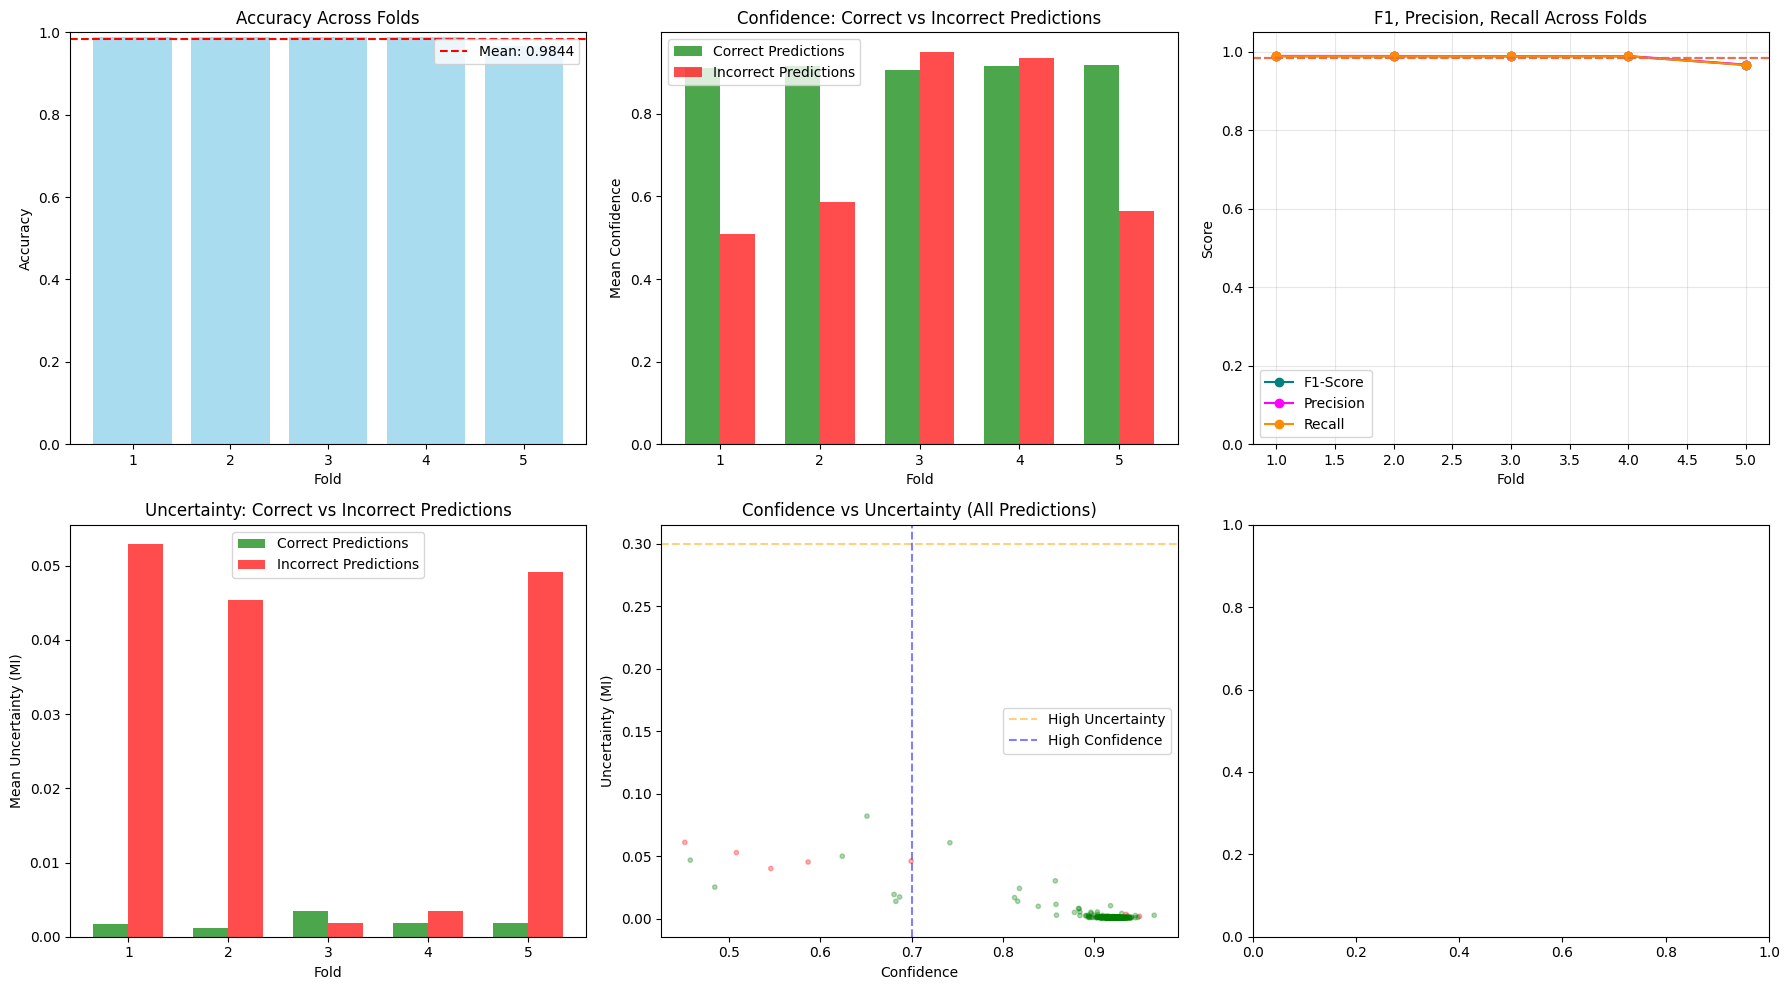


✅ Results saved to 'bioclinical_modernbert_mcd_kfold_results.json'


In [6]:
print("\n" + "="*80)
print("🚀 STARTING K-FOLD MONTE CARLO DROPOUT EVALUATION")
print("="*80)

# ✅ FIX: Use the SAME model throughout
classifier = MonteCarloDropoutClassifier(
    model_path=model_path,
    n_iterations=50
)

print(f"\n✅ Model loaded: {model_path}")
print(f"   Number of classes: {len(classifier.model.config.id2label)}")
print(f"   Classes: {list(classifier.model.config.id2label.values())}")
print(f"   Monte Carlo iterations: 50")
print(f"   Inference dropout rate: {classifier.inference_dropout_rate}")

# Initialize cross-validator
# Try to use GroupKFold if group_id exists in the dataset
try:
    groups = dataset['test']['group_id'] if 'group_id' in dataset['test'].column_names else None
except Exception:
    groups = None

cv = MCDCrossValidator(
    classifier=classifier,
    dataset=dataset['test'],  # Use the original test set with 'text'
    tokenizer=tokenizer, # Pass the tokenizer
    n_splits=5,  # 5-fold CV
    groups=groups
)

if groups is not None:
    print(f"✅ GroupKFold enabled (groups available: {len(set(groups))} unique)")
else:
    print("ℹ️ Group ids not found; falling back to regular KFold.")

# Run K-fold evaluation
aggregated_results, fold_results = cv.run_kfold_evaluation()

# Visualize results
cv.plot_results()

# Save results for thesis
import json
import numpy as np

# Function to convert numpy types to serializable types
def convert_numpy_types(obj):
    if isinstance(obj, (np.floating,)):
        return float(obj)
    elif isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

# Apply the conversion to the aggregated results
serializable_aggregated_results = {k: convert_numpy_types(v) for k, v in aggregated_results.items()}

# Apply the conversion to the fold results, excluding large arrays if desired
serializable_fold_results = []
for fold in fold_results:
    serializable_fold = {}
    for k, v in fold.items():
        if k not in ['predictions', 'labels', 'confidences', 'uncertainties', 'texts']:
            serializable_fold[k] = convert_numpy_types(v)
    # Keep small summaries for audit
    serializable_fold['n_samples'] = len(fold['labels'])
    serializable_fold_results.append(serializable_fold)

# Save to JSON with method and model information
with open('bioclinical_modernbert_mcd_kfold_results.json', 'w') as f:
    json.dump({
        'method': 'Monte Carlo Dropout (WITH Dropout)',
        'model': 'BioClinical-ModernBERT-base-Symptom2Disease_WITH-DROPOUT-42',
        'n_iterations': 50,
        'inference_dropout_rate': float(classifier.inference_dropout_rate),
        'aggregated': serializable_aggregated_results,
        'folds': serializable_fold_results
    }, f, indent=2)

print("\n✅ Results saved to 'bioclinical_modernbert_mcd_kfold_results.json'")
print("="*80)

# 5. Baseline BioClinical ModernBERT vs. MCD BioClinical ModernBERT Comparison

In [7]:
from transformers import pipeline

print("="*80)
print("📊 COMPARATIVE ANALYSIS: MCD vs BASELINE")
print("="*80)

# Initialize baseline pipeline (standard inference with dropout disabled)
baseline_classifier = pipeline(
    task="text-classification",
    model="notlath/BioClinical-ModernBERT-base-Symptom2Disease_WITH-DROPOUT-42", # Use the model loaded earlier
    tokenizer=tokenizer, # Use the tokenizer loaded earlier
    device=0 if torch.cuda.is_available() else -1,
)

# Re-initialize the MCD classifier
mcd_classifier = MonteCarloDropoutClassifier(
    model_path=model_path,
    n_iterations=50
)


# Collect comparison data on a subset of test samples (100 samples for efficiency)
comparison_samples = dataset['test'].select(range(min(100, len(dataset['test']))))

mcd_predictions = []
mcd_confidences = []
mcd_uncertainties = []
baseline_predictions = []
baseline_confidences = []
true_labels = []

print(f"\n🔄 Evaluating {len(comparison_samples)} samples with both methods...")

for i in tqdm(range(len(comparison_samples)), desc="Comparing MCD vs Baseline"):
    text = comparison_samples[i]['text']
    true_label = comparison_samples[i]['labels']

    # MCD prediction
    mcd_result = mcd_classifier.predict_with_uncertainty(text)
    mcd_pred = mcd_result['predicted_class'][0]
    mcd_conf = mcd_result['confidence'][0]
    mcd_mi = mcd_result['mutual_information'][0]

    # Baseline prediction
    baseline_result = baseline_classifier(text)[0]
    baseline_pred_label = baseline_result['label']
    # Need to convert baseline label string back to ID using the same mapping
    baseline_pred = classifier.model.config.label2id[baseline_pred_label]
    baseline_conf = baseline_result['score']

    # Store results
    mcd_predictions.append(mcd_pred)
    mcd_confidences.append(mcd_conf)
    mcd_uncertainties.append(mcd_mi)
    baseline_predictions.append(baseline_pred)
    baseline_confidences.append(baseline_conf)
    true_labels.append(true_label)

# Convert to numpy arrays
mcd_predictions = np.array(mcd_predictions)
baseline_predictions = np.array(baseline_predictions)
mcd_confidences = np.array(mcd_confidences)
baseline_confidences = np.array(baseline_confidences)
mcd_uncertainties = np.array(mcd_uncertainties)
true_labels = np.array(true_labels)

# Calculate metrics
mcd_accuracy = (mcd_predictions == true_labels).mean()
baseline_accuracy = (baseline_predictions == true_labels).mean()
agreement_rate = (mcd_predictions == baseline_predictions).mean()

mcd_correct = mcd_predictions == true_labels
baseline_correct = baseline_predictions == true_labels

print(f"\n📈 OVERALL PERFORMANCE:")
print(f"   MCD Accuracy:      {mcd_accuracy:.4f} ({int(mcd_accuracy*100)}%)")
print(f"   Baseline Accuracy: {baseline_accuracy:.4f} ({int(baseline_accuracy*100)}%)")
print(f"   Agreement Rate:    {agreement_rate:.4f} ({int(agreement_rate*100)}%)")

print(f"\n🎯 CONFIDENCE ANALYSIS:")
print(f"   Mean MCD Confidence:      {mcd_confidences.mean():.4f} ± {mcd_confidences.std():.4f}")
print(f"   Mean Baseline Confidence: {baseline_confidences.mean():.4f} ± {baseline_confidences.std():.4f}")
print(f"   Confidence Difference:    {(baseline_confidences.mean() - mcd_confidences.mean()):.4f}")

print(f"\n✅ CALIBRATION ANALYSIS:")
# Handle cases where there are no correct or incorrect predictions
mcd_conf_correct_mean = mcd_confidences[mcd_correct].mean() if mcd_correct.any() else 0.0
mcd_conf_incorrect_mean = mcd_confidences[~mcd_correct].mean() if (~mcd_correct).any() else 0.0
baseline_conf_correct_mean = baseline_confidences[baseline_correct].mean() if baseline_correct.any() else 0.0
baseline_conf_incorrect_mean = baseline_confidences[~baseline_correct].mean() if (~baseline_correct).any() else 0.0

print(f"   MCD Confidence (Correct):      {mcd_conf_correct_mean:.4f}")
print(f"   MCD Confidence (Incorrect):    {mcd_conf_incorrect_mean:.4f}")
print(f"   Baseline Confidence (Correct):     {baseline_conf_correct_mean:.4f}")
print(f"   Baseline Confidence (Incorrect):   {baseline_conf_incorrect_mean:.4f}")


print(f"\n🔍 UNCERTAINTY INSIGHTS:")
# Handle cases where there are no correct or incorrect predictions for uncertainty
mcd_unc_correct_mean = mcd_uncertainties[mcd_correct].mean() if mcd_correct.any() else 0.0
mcd_unc_incorrect_mean = mcd_uncertainties[~mcd_correct].mean() if (~mcd_correct).any() else 0.0

print(f"   Mean MCD Uncertainty (MI):     {mcd_uncertainties.mean():.4f} ± {mcd_uncertainties.std():.4f}")
print(f"   MCD Uncertainty (Correct):     {mcd_unc_correct_mean:.4f}")
print(f"   MCD Uncertainty (Incorrect):   {mcd_unc_incorrect_mean:.4f}")

uncertainty_separation = mcd_unc_incorrect_mean - mcd_unc_correct_mean
print(f"   Separation:                    {uncertainty_separation:.4f}")

print(f"\n⚖️ DISAGREEMENT ANALYSIS:")
disagreements = mcd_predictions != baseline_predictions
num_disagreements = disagreements.sum()
print(f"   Total Disagreements: {num_disagreements} ({num_disagreements/len(comparison_samples)*100:.1f}%)")

if num_disagreements > 0:
    # Who's right when they disagree?
    mcd_right_baseline_wrong = (mcd_correct & ~baseline_correct).sum()
    baseline_right_mcd_wrong = (~mcd_correct & baseline_correct).sum()
    both_wrong = (~mcd_correct & ~baseline_correct & disagreements).sum()

    print(f"   MCD Correct, Baseline Wrong:  {mcd_right_baseline_wrong}")
    print(f"   Baseline Correct, MCD Wrong:  {baseline_right_mcd_wrong}")
    print(f"   Both Wrong (disagreements):   {both_wrong}")

    # Average uncertainty in disagreement cases
    if disagreements.sum() > 0:
        avg_uncertainty_disagreements = mcd_uncertainties[disagreements].mean()
        print(f"   Avg MCD Uncertainty (disagreements): {avg_uncertainty_disagreements:.4f}")
        print(f"   (This should be higher than overall average, indicating MCD flags uncertain cases)")

print(f"\n💡 KEY INSIGHTS:")
if mcd_confidences.mean() < baseline_confidences.mean():
    print(f"   ✓ MCD provides more conservative confidence estimates (better calibration)")
if uncertainty_separation > 0.05: # Using a threshold to check for meaningful separation
    print(f"   ✓ MCD uncertainty successfully discriminates correct vs incorrect predictions")
if mcd_accuracy >= baseline_accuracy:
    print(f"   ✓ MCD maintains or improves accuracy while providing uncertainty estimates")

print("="*80)

📊 COMPARATIVE ANALYSIS: MCD vs BASELINE


Device set to use cuda:0



🔄 Evaluating 100 samples with both methods...


Comparing MCD vs Baseline: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


📈 OVERALL PERFORMANCE:
   MCD Accuracy:      0.9800 (98%)
   Baseline Accuracy: 0.9800 (98%)
   Agreement Rate:    1.0000 (100%)

🎯 CONFIDENCE ANALYSIS:
   Mean MCD Confidence:      0.9045 ± 0.0646
   Mean Baseline Confidence: 0.9137 ± 0.0513
   Confidence Difference:    0.0092

✅ CALIBRATION ANALYSIS:
   MCD Confidence (Correct):      0.9085
   MCD Confidence (Incorrect):    0.7094
   Baseline Confidence (Correct):     0.9167
   Baseline Confidence (Incorrect):   0.7674

🔍 UNCERTAINTY INSIGHTS:
   Mean MCD Uncertainty (MI):     0.0040 ± 0.0126
   MCD Uncertainty (Correct):     0.0036
   MCD Uncertainty (Incorrect):   0.0235
   Separation:                    0.0199

⚖️ DISAGREEMENT ANALYSIS:
   Total Disagreements: 0 (0.0%)

💡 KEY INSIGHTS:
   ✓ MCD provides more conservative confidence estimates (better calibration)
   ✓ MCD maintains or improves accuracy while providing uncertainty estimates


/tmp/ipython-input-1920444338.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_comparison, x='Method', y='Confidence', ax=axes[1, 2], palette=['lightblue', 'lightcoral', 'lightgreen', 'salmon'])


✅ Visualization saved to 'mcd_vs_baseline_comparison.png'


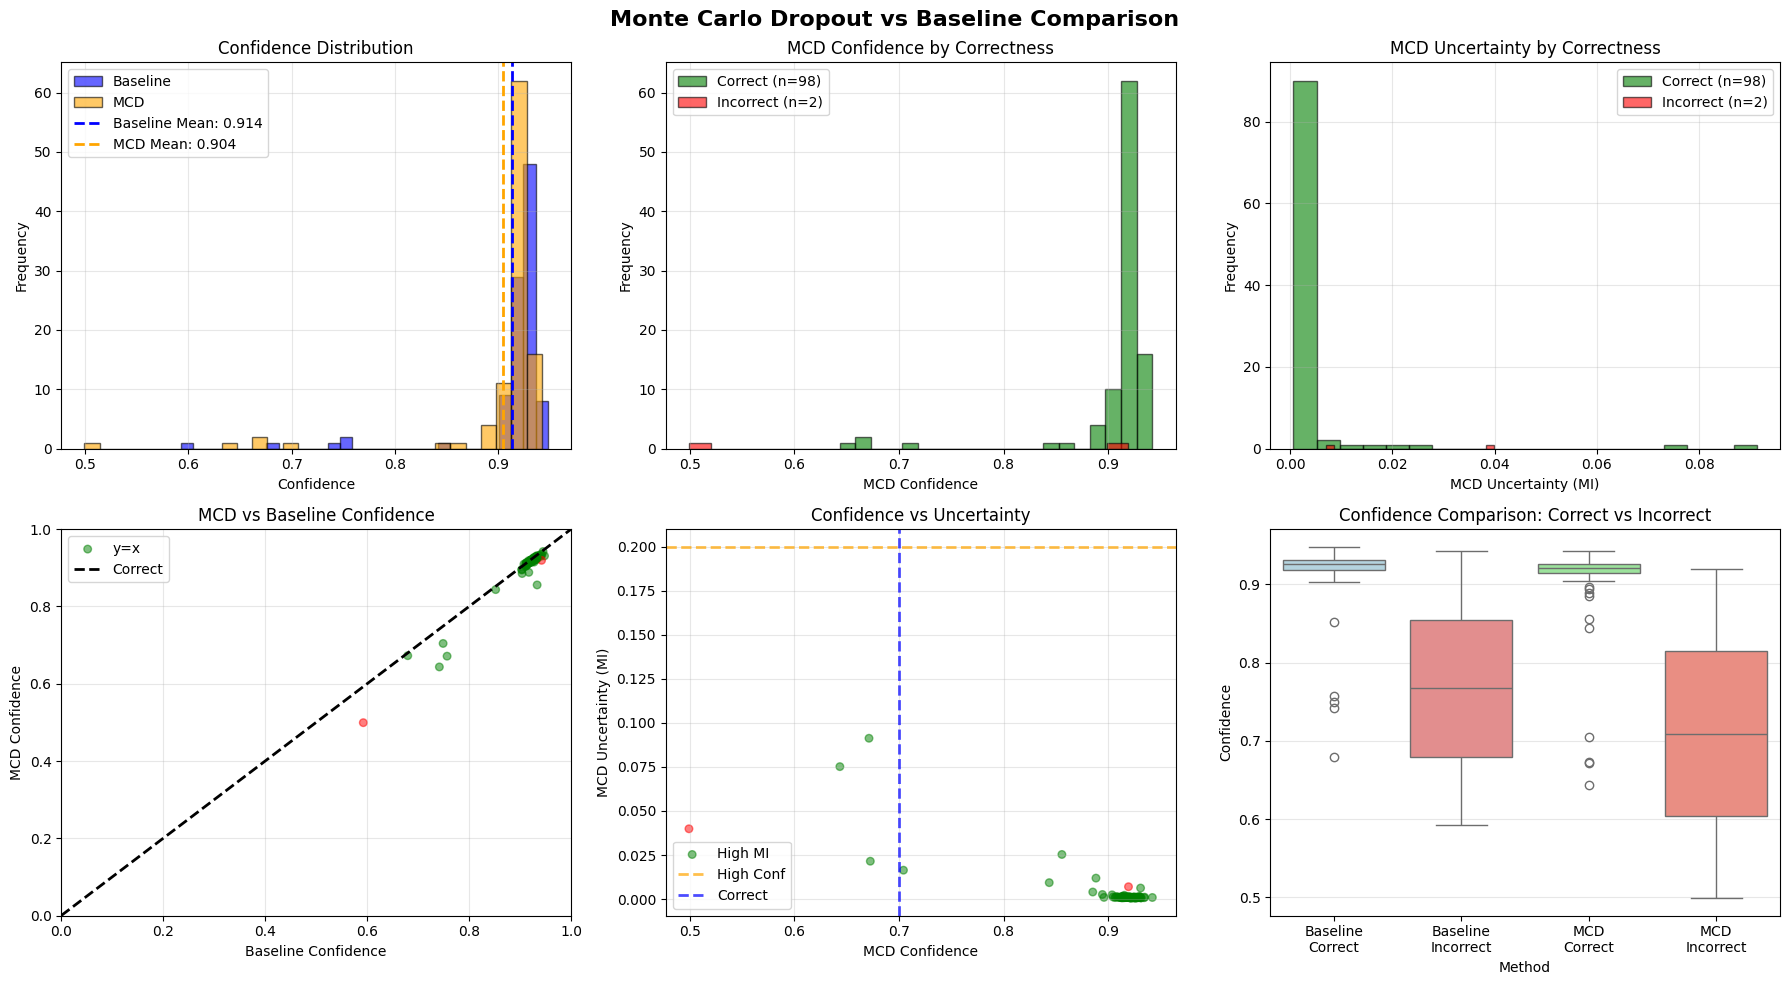

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Monte Carlo Dropout vs Baseline Comparison', fontsize=16, fontweight='bold')

# 1. Confidence Distribution Comparison
axes[0, 0].hist(baseline_confidences, bins=30, alpha=0.6, label='Baseline', color='blue', edgecolor='black')
axes[0, 0].hist(mcd_confidences, bins=30, alpha=0.6, label='MCD', color='orange', edgecolor='black')
axes[0, 0].axvline(baseline_confidences.mean(), color='blue', linestyle='--', linewidth=2, label=f'Baseline Mean: {baseline_confidences.mean():.3f}')
axes[0, 0].axvline(mcd_confidences.mean(), color='orange', linestyle='--', linewidth=2, label=f'MCD Mean: {mcd_confidences.mean():.3f}')
axes[0, 0].set_xlabel('Confidence')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Confidence Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Confidence: Correct vs Incorrect (MCD)
correct_mcd = mcd_confidences[mcd_correct]
incorrect_mcd = mcd_confidences[~mcd_correct]
axes[0, 1].hist(correct_mcd, bins=20, alpha=0.6, label=f'Correct (n={len(correct_mcd)})', color='green', edgecolor='black')
axes[0, 1].hist(incorrect_mcd, bins=20, alpha=0.6, label=f'Incorrect (n={len(incorrect_mcd)})', color='red', edgecolor='black')
axes[0, 1].set_xlabel('MCD Confidence')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('MCD Confidence by Correctness')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Uncertainty by Correctness (MCD)
correct_unc = mcd_uncertainties[mcd_correct]
incorrect_unc = mcd_uncertainties[~mcd_correct]
axes[0, 2].hist(correct_unc, bins=20, alpha=0.6, label=f'Correct (n={len(correct_unc)})', color='green', edgecolor='black')
axes[0, 2].hist(incorrect_unc, bins=20, alpha=0.6, label=f'Incorrect (n={len(incorrect_unc)})', color='red', edgecolor='black')
axes[0, 2].set_xlabel('MCD Uncertainty (MI)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('MCD Uncertainty by Correctness')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. MCD Confidence vs Baseline Confidence
axes[1, 0].scatter(baseline_confidences, mcd_confidences, alpha=0.5, c=['green' if c else 'red' for c in mcd_correct], s=30)
axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='y=x (Perfect Agreement)')
axes[1, 0].set_xlabel('Baseline Confidence')
axes[1, 0].set_ylabel('MCD Confidence')
axes[1, 0].set_title('MCD vs Baseline Confidence')
axes[1, 0].legend(['y=x', 'Correct', 'Incorrect'])
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])

# 5. Confidence vs Uncertainty Scatter
colors = ['green' if c else 'red' for c in mcd_correct]
axes[1, 1].scatter(mcd_confidences, mcd_uncertainties, c=colors, alpha=0.5, s=30)
axes[1, 1].axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='High Uncertainty Threshold')
axes[1, 1].axvline(x=0.7, color='blue', linestyle='--', alpha=0.7, linewidth=2, label='High Confidence Threshold')
axes[1, 1].set_xlabel('MCD Confidence')
axes[1, 1].set_ylabel('MCD Uncertainty (MI)')
axes[1, 1].set_title('Confidence vs Uncertainty')
axes[1, 1].legend(['High MI', 'High Conf', 'Correct', 'Incorrect'])
axes[1, 1].grid(alpha=0.3)

# 6. Box plot comparison
comparison_data = []
comparison_labels = []

comparison_data.extend(baseline_confidences[baseline_correct])
comparison_labels.extend(['Baseline\nCorrect'] * len(baseline_confidences[baseline_correct]))

comparison_data.extend(baseline_confidences[~baseline_correct])
comparison_labels.extend(['Baseline\nIncorrect'] * len(baseline_confidences[~baseline_correct]))

comparison_data.extend(mcd_confidences[mcd_correct])
comparison_labels.extend(['MCD\nCorrect'] * len(mcd_confidences[mcd_correct]))

comparison_data.extend(mcd_confidences[~mcd_correct])
comparison_labels.extend(['MCD\nIncorrect'] * len(mcd_confidences[~mcd_correct]))

import pandas as pd
df_comparison = pd.DataFrame({'Confidence': comparison_data, 'Method': comparison_labels})
sns.boxplot(data=df_comparison, x='Method', y='Confidence', ax=axes[1, 2], palette=['lightblue', 'lightcoral', 'lightgreen', 'salmon'])
axes[1, 2].set_title('Confidence Comparison: Correct vs Incorrect')
axes[1, 2].set_ylabel('Confidence')
axes[1, 2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('mcd_vs_baseline_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved to 'mcd_vs_baseline_comparison.png'")
plt.show()

# 6. Inference Dropout Sensitivity Analysis

In [9]:
print("="*80)
print("🔬 INFERENCE DROPOUT RATE SENSITIVITY ANALYSIS")
print("="*80)

# Test subset (100 samples for efficiency, can increase for final analysis)
test_subset = dataset['test'].select(range(min(100, len(dataset['test']))))

# Inference dropout rates to test
inference_dropout_rates = [0.0, 0.025, 0.05, 0.075, 0.1, 0.15]

# Storage for results
dropout_rate_results = []

for rate in inference_dropout_rates:
    print(f"\n{'='*80}")
    print(f"🎲 Testing Inference Dropout Rate: {rate}")
    print(f"{'='*80}")

    # Initialize classifier with specific dropout rate
    classifier_temp = MonteCarloDropoutClassifier(
        model_path=model_path,
        n_iterations=50,
        inference_dropout_rate=rate
    )

    # Collect predictions and metrics
    predictions = []
    confidences = []
    uncertainties = []
    entropies = []
    true_labels = []
    prediction_stds = []  # Track prediction stability

    print(f"🔄 Evaluating {len(test_subset)} samples with dropout rate {rate}...")

    for i in tqdm(range(len(test_subset)), desc=f"Rate {rate}"):
        text = test_subset[i]['text']
        true_label = test_subset[i]['labels']

        # Get MCD prediction
        result = classifier_temp.predict_with_uncertainty(text)

        pred_class = result['predicted_class'][0]
        conf = result['confidence'][0]
        mi = result['mutual_information'][0]
        ent = result['predictive_entropy'][0]

        # Calculate prediction stability (std of max prob across iterations)
        all_preds_array = result['all_predictions']  # shape: (n_iterations, batch, n_classes)
        max_probs_per_iter = all_preds_array[:, 0, :].max(axis=1)  # max prob per iteration
        pred_std = max_probs_per_iter.std()

        predictions.append(pred_class)
        confidences.append(conf)
        uncertainties.append(mi)
        entropies.append(ent)
        true_labels.append(true_label)
        prediction_stds.append(pred_std)

    # Convert to numpy
    predictions = np.array(predictions)
    confidences = np.array(confidences)
    uncertainties = np.array(uncertainties)
    entropies = np.array(entropies)
    true_labels = np.array(true_labels)
    prediction_stds = np.array(prediction_stds)

    # Calculate metrics
    correct = predictions == true_labels
    accuracy = correct.mean()

    # Confidence metrics
    conf_correct = confidences[correct].mean() if correct.any() else 0.0
    conf_incorrect = confidences[~correct].mean() if (~correct).any() else 0.0
    conf_separation = conf_correct - conf_incorrect

    # Uncertainty metrics
    unc_correct = uncertainties[correct].mean() if correct.any() else 0.0
    unc_incorrect = uncertainties[~correct].mean() if (~correct).any() else 0.0
    unc_separation = unc_incorrect - unc_correct  # Higher is better (incorrect should have higher MI)

    # Prediction stability
    mean_pred_std = prediction_stds.mean()

    # Store results
    result_dict = {
        'dropout_rate': rate,
        'accuracy': accuracy,
        'mean_confidence': confidences.mean(),
        'confidence_correct': conf_correct,
        'confidence_incorrect': conf_incorrect,
        'confidence_separation': conf_separation,
        'mean_uncertainty': uncertainties.mean(),
        'uncertainty_correct': unc_correct,
        'uncertainty_incorrect': unc_incorrect,
        'uncertainty_separation': unc_separation,
        'mean_entropy': entropies.mean(),
        'mean_prediction_std': mean_pred_std,
        'n_correct': correct.sum(),
        'n_incorrect': (~correct).sum()
    }

    dropout_rate_results.append(result_dict)

    # Print summary
    print(f"\n📊 RESULTS for dropout rate {rate}:")
    print(f"   Accuracy:                    {accuracy:.4f} ({int(accuracy*100)}%)")
    print(f"   Mean Confidence:             {confidences.mean():.4f}")
    print(f"   Confidence (Correct):        {conf_correct:.4f}")
    print(f"   Confidence (Incorrect):      {conf_incorrect:.4f}")
    print(f"   Confidence Separation:       {conf_separation:.4f}")
    print(f"   Mean Uncertainty (MI):       {uncertainties.mean():.4f}")
    print(f"   Uncertainty (Correct):       {unc_correct:.4f}")
    print(f"   Uncertainty (Incorrect):     {unc_incorrect:.4f}")
    print(f"   Uncertainty Separation:      {unc_separation:.4f} {'✓ GOOD' if unc_separation > 0.05 else ''}")
    print(f"   Mean Prediction Std:         {mean_pred_std:.4f}")

print(f"\n{'='*80}")
print("✅ DROPOUT RATE SENSITIVITY ANALYSIS COMPLETE")
print("="*80)

# Create comparison DataFrame
import pandas as pd
df_dropout_comparison = pd.DataFrame(dropout_rate_results)
print("\n📊 SUMMARY TABLE:")
print(df_dropout_comparison.to_string(index=False))

# Save results
import json

# Convert numpy types for JSON serialization
def convert_for_json(obj):
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    return obj

serializable_results = [{k: convert_for_json(v) for k, v in result.items()}
                        for result in dropout_rate_results]

with open('dropout_rate_sensitivity_analysis.json', 'w') as f:
    json.dump({
        'experiment': 'Inference Dropout Rate Sensitivity Analysis',
        'model': model_path,
        'n_iterations': 50,
        'test_samples': len(test_subset),
        'results': serializable_results
    }, f, indent=2)

print("\n✅ Results saved to 'dropout_rate_sensitivity_analysis.json'")

🔬 INFERENCE DROPOUT RATE SENSITIVITY ANALYSIS

🎲 Testing Inference Dropout Rate: 0.0
🔄 Evaluating 100 samples with dropout rate 0.0...


Rate 0.0: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it]



📊 RESULTS for dropout rate 0.0:
   Accuracy:                    0.9800 (98%)
   Mean Confidence:             0.9137
   Confidence (Correct):        0.9167
   Confidence (Incorrect):      0.7674
   Confidence Separation:       0.1493
   Mean Uncertainty (MI):       0.0000
   Uncertainty (Correct):       0.0000
   Uncertainty (Incorrect):     -0.0000
   Uncertainty Separation:      -0.0000 
   Mean Prediction Std:         0.0000

🎲 Testing Inference Dropout Rate: 0.025
🔄 Evaluating 100 samples with dropout rate 0.025...


Rate 0.025: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it]



📊 RESULTS for dropout rate 0.025:
   Accuracy:                    0.9800 (98%)
   Mean Confidence:             0.9098
   Confidence (Correct):        0.9131
   Confidence (Incorrect):      0.7448
   Confidence Separation:       0.1684
   Mean Uncertainty (MI):       0.0021
   Uncertainty (Correct):       0.0018
   Uncertainty (Incorrect):     0.0151
   Uncertainty Separation:      0.0133 
   Mean Prediction Std:         0.0111

🎲 Testing Inference Dropout Rate: 0.05
🔄 Evaluating 100 samples with dropout rate 0.05...


Rate 0.05: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it]



📊 RESULTS for dropout rate 0.05:
   Accuracy:                    0.9800 (98%)
   Mean Confidence:             0.9049
   Confidence (Correct):        0.9088
   Confidence (Incorrect):      0.7158
   Confidence Separation:       0.1930
   Mean Uncertainty (MI):       0.0042
   Uncertainty (Correct):       0.0037
   Uncertainty (Incorrect):     0.0263
   Uncertainty Separation:      0.0226 
   Mean Prediction Std:         0.0158

🎲 Testing Inference Dropout Rate: 0.075
🔄 Evaluating 100 samples with dropout rate 0.075...


Rate 0.075: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]



📊 RESULTS for dropout rate 0.075:
   Accuracy:                    0.9900 (99%)
   Mean Confidence:             0.9012
   Confidence (Correct):        0.9011
   Confidence (Incorrect):      0.9071
   Confidence Separation:       -0.0060
   Mean Uncertainty (MI):       0.0053
   Uncertainty (Correct):       0.0052
   Uncertainty (Incorrect):     0.0160
   Uncertainty Separation:      0.0108 
   Mean Prediction Std:         0.0194

🎲 Testing Inference Dropout Rate: 0.1
🔄 Evaluating 100 samples with dropout rate 0.1...


Rate 0.1: 100%|██████████| 100/100 [02:26<00:00,  1.46s/it]



📊 RESULTS for dropout rate 0.1:
   Accuracy:                    0.9900 (99%)
   Mean Confidence:             0.8947
   Confidence (Correct):        0.8949
   Confidence (Incorrect):      0.8753
   Confidence Separation:       0.0196
   Mean Uncertainty (MI):       0.0087
   Uncertainty (Correct):       0.0084
   Uncertainty (Incorrect):     0.0396
   Uncertainty Separation:      0.0312 
   Mean Prediction Std:         0.0237

🎲 Testing Inference Dropout Rate: 0.15
🔄 Evaluating 100 samples with dropout rate 0.15...


Rate 0.15: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


📊 RESULTS for dropout rate 0.15:
   Accuracy:                    0.9900 (99%)
   Mean Confidence:             0.8833
   Confidence (Correct):        0.8838
   Confidence (Incorrect):      0.8364
   Confidence Separation:       0.0474
   Mean Uncertainty (MI):       0.0149
   Uncertainty (Correct):       0.0143
   Uncertainty (Incorrect):     0.0742
   Uncertainty Separation:      0.0600 ✓ GOOD
   Mean Prediction Std:         0.0315

✅ DROPOUT RATE SENSITIVITY ANALYSIS COMPLETE

📊 SUMMARY TABLE:
 dropout_rate  accuracy  mean_confidence  confidence_correct  confidence_incorrect  confidence_separation  mean_uncertainty  uncertainty_correct  uncertainty_incorrect  uncertainty_separation  mean_entropy  mean_prediction_std  n_correct  n_incorrect
        0.000      0.98         0.913671            0.916656              0.767395               0.149261      5.662441e-09         8.514950e-09          -1.341105e-07           -1.426254e-07      0.413368         4.291535e-08         98           

✅ Visualization saved to 'dropout_rate_sensitivity_analysis.png'


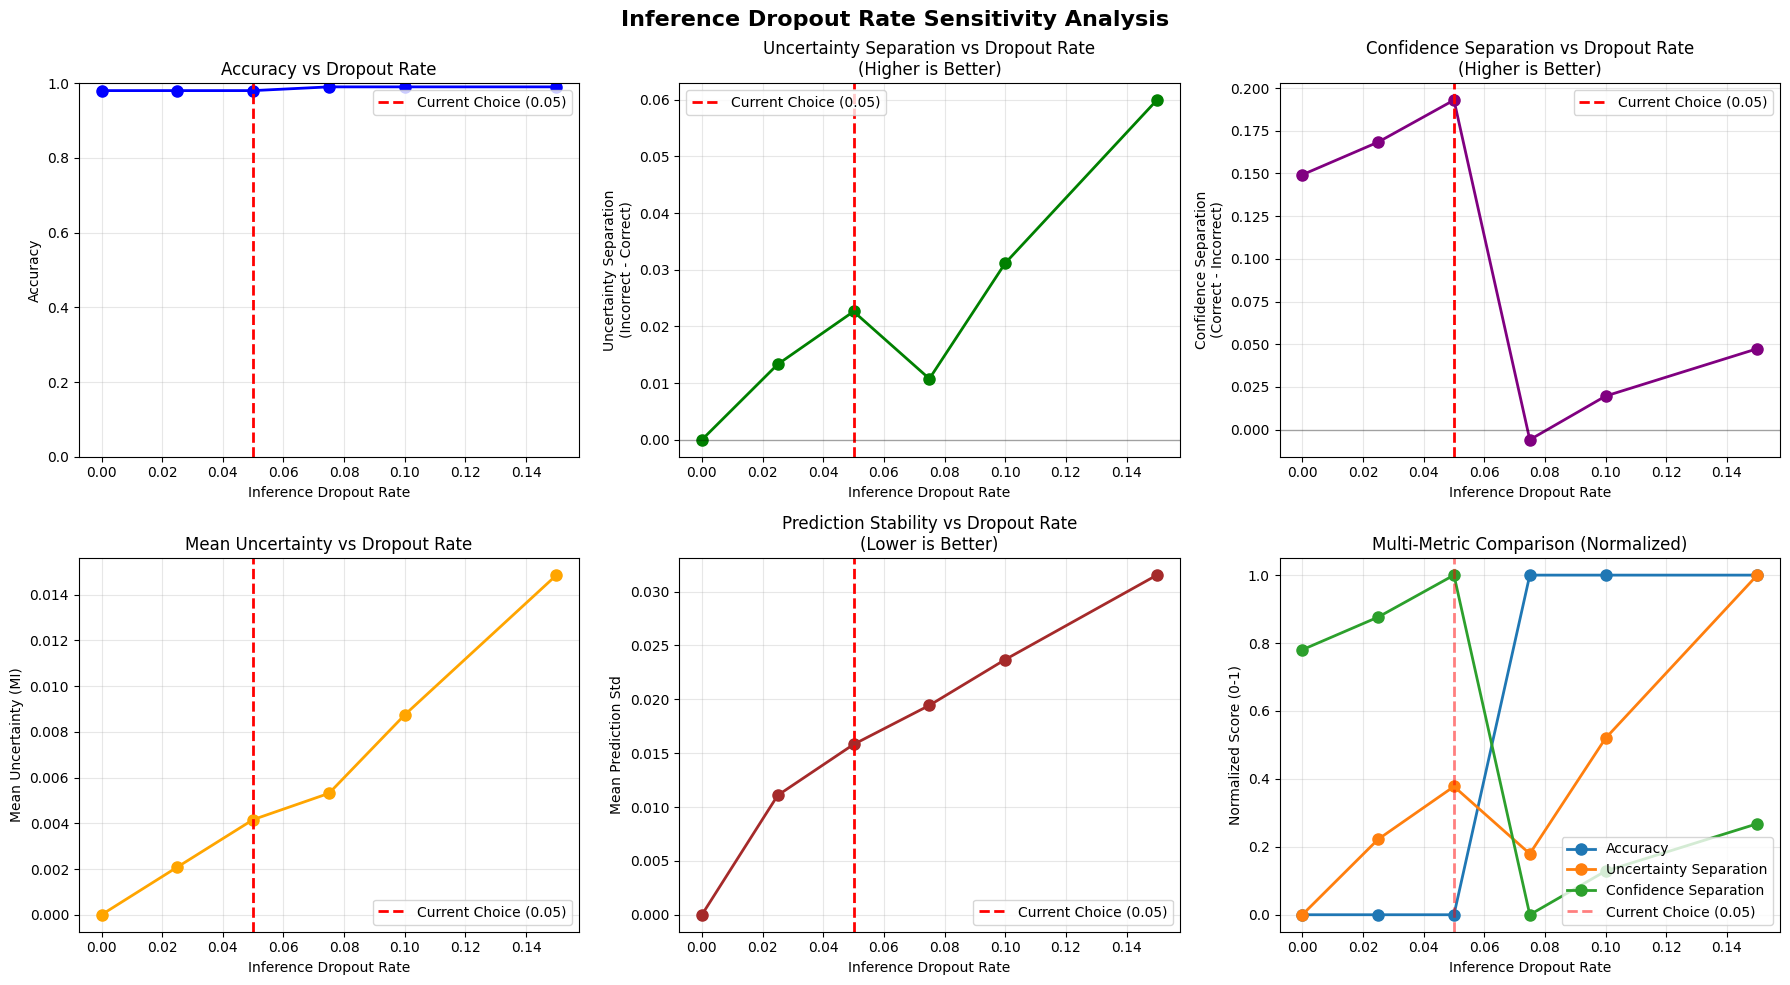


🎯 RECOMMENDATION

📊 Based on composite scoring (accuracy + unc_sep + conf_sep - pred_std):
   Optimal Dropout Rate: 0.05
   Current Choice: 0.05

   ✅ CONFIRMED: 0.05 is the optimal choice!

💡 Key Findings:
   Dropout rate 0.05 achieves:
      Accuracy: 0.9800
      Uncertainty Separation: 0.0226
      Confidence Separation: 0.1930
      Prediction Stability (std): 0.0158


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Inference Dropout Rate Sensitivity Analysis', fontsize=16, fontweight='bold')

dropout_rates = df_dropout_comparison['dropout_rate'].values

# 1. Accuracy vs Dropout Rate
axes[0, 0].plot(dropout_rates, df_dropout_comparison['accuracy'], 'o-', linewidth=2, markersize=8, color='blue')
axes[0, 0].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Current Choice (0.05)')
axes[0, 0].set_xlabel('Inference Dropout Rate')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs Dropout Rate')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# 2. Uncertainty Separation vs Dropout Rate
axes[0, 1].plot(dropout_rates, df_dropout_comparison['uncertainty_separation'], 'o-', linewidth=2, markersize=8, color='green')
axes[0, 1].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Current Choice (0.05)')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
axes[0, 1].set_xlabel('Inference Dropout Rate')
axes[0, 1].set_ylabel('Uncertainty Separation\n(Incorrect - Correct)')
axes[0, 1].set_title('Uncertainty Separation vs Dropout Rate\n(Higher is Better)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Confidence Separation vs Dropout Rate
axes[0, 2].plot(dropout_rates, df_dropout_comparison['confidence_separation'], 'o-', linewidth=2, markersize=8, color='purple')
axes[0, 2].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Current Choice (0.05)')
axes[0, 2].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
axes[0, 2].set_xlabel('Inference Dropout Rate')
axes[0, 2].set_ylabel('Confidence Separation\n(Correct - Incorrect)')
axes[0, 2].set_title('Confidence Separation vs Dropout Rate\n(Higher is Better)')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Mean Uncertainty vs Dropout Rate
axes[1, 0].plot(dropout_rates, df_dropout_comparison['mean_uncertainty'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 0].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Current Choice (0.05)')
axes[1, 0].set_xlabel('Inference Dropout Rate')
axes[1, 0].set_ylabel('Mean Uncertainty (MI)')
axes[1, 0].set_title('Mean Uncertainty vs Dropout Rate')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Prediction Stability (Std) vs Dropout Rate
axes[1, 1].plot(dropout_rates, df_dropout_comparison['mean_prediction_std'], 'o-', linewidth=2, markersize=8, color='brown')
axes[1, 1].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Current Choice (0.05)')
axes[1, 1].set_xlabel('Inference Dropout Rate')
axes[1, 1].set_ylabel('Mean Prediction Std')
axes[1, 1].set_title('Prediction Stability vs Dropout Rate\n(Lower is Better)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Multi-metric comparison (normalized)
# Normalize metrics to 0-1 scale for comparison
from sklearn.preprocessing import MinMaxScaler

metrics_to_plot = ['accuracy', 'uncertainty_separation', 'confidence_separation']
scaler = MinMaxScaler()

normalized_data = df_dropout_comparison[metrics_to_plot].copy()
normalized_data = pd.DataFrame(
    scaler.fit_transform(normalized_data),
    columns=metrics_to_plot
)

for metric in metrics_to_plot:
    axes[1, 2].plot(dropout_rates, normalized_data[metric], 'o-', linewidth=2, markersize=8, label=metric.replace('_', ' ').title())

axes[1, 2].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Current Choice (0.05)', alpha=0.5)
axes[1, 2].set_xlabel('Inference Dropout Rate')
axes[1, 2].set_ylabel('Normalized Score (0-1)')
axes[1, 2].set_title('Multi-Metric Comparison (Normalized)')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dropout_rate_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved to 'dropout_rate_sensitivity_analysis.png'")
plt.show()

# Print recommendation
print("\n" + "="*80)
print("🎯 RECOMMENDATION")
print("="*80)

# Find optimal dropout rate based on composite score
df_dropout_comparison['composite_score'] = (
    df_dropout_comparison['accuracy'] +
    df_dropout_comparison['uncertainty_separation'] +
    df_dropout_comparison['confidence_separation'] -
    df_dropout_comparison['mean_prediction_std']
)

optimal_idx = df_dropout_comparison['composite_score'].idxmax()
optimal_rate = df_dropout_comparison.loc[optimal_idx, 'dropout_rate']

print(f"\n📊 Based on composite scoring (accuracy + unc_sep + conf_sep - pred_std):")
print(f"   Optimal Dropout Rate: {optimal_rate}")
print(f"   Current Choice: 0.05")

if optimal_rate == 0.05:
    print(f"\n   ✅ CONFIRMED: 0.05 is the optimal choice!")
else:
    print(f"\n   ⚠️  Analysis suggests {optimal_rate} may be better than 0.05")
    print(f"   Consider reviewing trade-offs")

print("\n💡 Key Findings:")
rate_05_data = df_dropout_comparison[df_dropout_comparison['dropout_rate'] == 0.05].iloc[0]
print(f"   Dropout rate 0.05 achieves:")
print(f"      Accuracy: {rate_05_data['accuracy']:.4f}")
print(f"      Uncertainty Separation: {rate_05_data['uncertainty_separation']:.4f}")
print(f"      Confidence Separation: {rate_05_data['confidence_separation']:.4f}")
print(f"      Prediction Stability (std): {rate_05_data['mean_prediction_std']:.4f}")

print("="*80)

# Confusion Matrix


📈 CONFUSION MATRIX ANALYSIS: MCD vs BASELINE
✅ Confusion Matrix (MCD) saved to 'confusion_matrix_mcd.png'


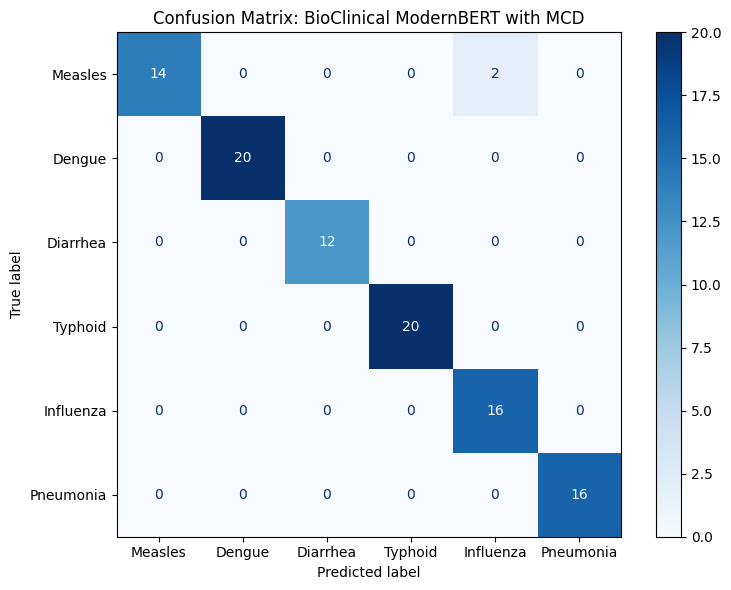

✅ Confusion Matrix (Baseline) saved to 'confusion_matrix_baseline.png'


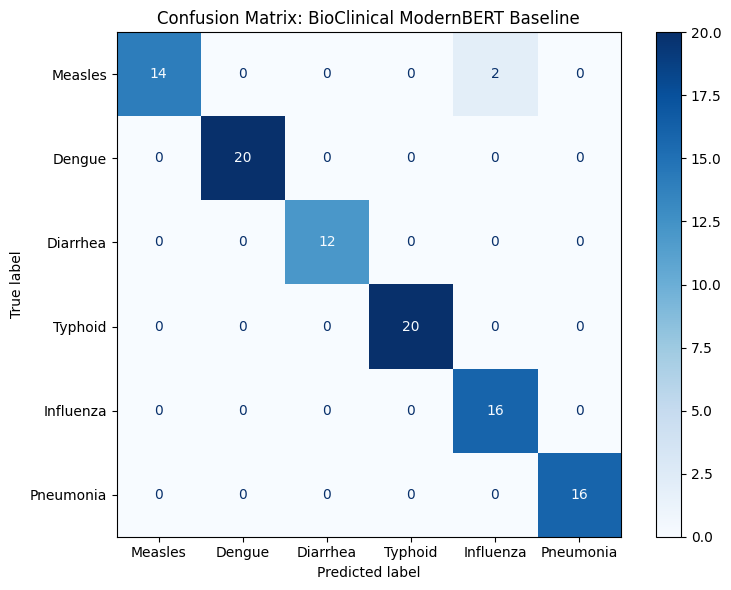

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("📈 CONFUSION MATRIX ANALYSIS: MCD vs BASELINE")
print("="*80)

# Ensure true_labels, mcd_predictions, and baseline_predictions are available
# These were generated in the previous comparison cell (y1e11Ci9Sf_y)
# If that cell wasn't run, this cell will fail.

if 'true_labels' not in locals() or 'mcd_predictions' not in locals() or 'baseline_predictions' not in locals():
    print("⚠️  Error: Comparison results (true_labels, mcd_predictions, baseline_predictions) not found.")
    print("   Please run the 'MCD vs Baseline Comparison' cell first.")
else:
    # Get the label names from the model config
    # Use the classifier object which should still be in scope
    if 'classifier' in locals() and hasattr(classifier.model.config, 'id2label'):
        display_labels = [classifier.model.config.id2label[i] for i in sorted(classifier.model.config.id2label.keys())]
    else:
        # Fallback if classifier object is not available or lacks id2label
        print("⚠️  Warning: Could not retrieve label names from classifier object. Using numerical labels.")
        display_labels = sorted(list(np.unique(true_labels))) # Use unique labels found in data


    # 1. Confusion Matrix for MCD
    cm_mcd = confusion_matrix(true_labels, mcd_predictions)
    disp_mcd = ConfusionMatrixDisplay(confusion_matrix=cm_mcd, display_labels=display_labels)

    fig_mcd, ax_mcd = plt.subplots(figsize=(8, 6))
    disp_mcd.plot(cmap=plt.cm.Blues, ax=ax_mcd)
    ax_mcd.set_title('Confusion Matrix: BioClinical ModernBERT with MCD')
    plt.tight_layout()
    plt.savefig('confusion_matrix_mcd.png', dpi=300)
    print("✅ Confusion Matrix (MCD) saved to 'confusion_matrix_mcd.png'")
    plt.show()

    # 2. Confusion Matrix for Baseline
    cm_baseline = confusion_matrix(true_labels, baseline_predictions)
    disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=display_labels)

    fig_baseline, ax_baseline = plt.subplots(figsize=(8, 6))
    disp_baseline.plot(cmap=plt.cm.Blues, ax=ax_baseline)
    ax_baseline.set_title('Confusion Matrix: BioClinical ModernBERT Baseline')
    plt.tight_layout()
    plt.savefig('confusion_matrix_baseline.png', dpi=300)
    print("✅ Confusion Matrix (Baseline) saved to 'confusion_matrix_baseline.png'")
    plt.show()

print("="*80)